# PUBG Finish Placement Prediction

Author : Choi, Ju ho , chlwnch@naver.com

Supervisor : Na, In Seop, ypencil@hanmail.net

Starting Project : 2019.1.4

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sc
import gc
import warnings

In [ ]:
plt.rcParams['figure.figsize'] = 15,8
sns.set(rc={'figure.figsize':(15,8)})
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
gc.enable()

In [ ]:
train = pd.read_csv('../Pubg-predict/input/train_V2.csv')
test = pd.read_csv('../Pubg-predict/input/test_V2.csv')
train.head()

In [ ]:
train.info()

In [ ]:
#NaN (결측)값이 있는 행을 찾아서 발견하면 null_cnt의 수를 증가
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])
# dropna 를 이용하여 결측값이 있는 행을 제거
train.dropna(inplace=True)

In [ ]:
train.describe()

In [ ]:
train['winPlacePerc'].hist(bins=25);

In [ ]:
print(sc.normaltest(train['winPlacePerc']))
print('Skew: ', sc.skew(train['winPlacePerc']))

In [ ]:
def featStat(featureName, constrain,plotType):
    feat = train[featureName][train[featureName]>0]
    data = train[[featureName,'winPlacePerc']].copy()
    q99 = int(data[featureName].quantile(0.99))
    plt.rcParams['figure.figsize'] = 15,5;   
    
    if constrain!=None:
        feat = feat[feat<constrain]
    if plotType == 'hist':
        plt.subplot(1,2,1)
        feat.hist(bins=50);
        plt.title(featureName);
        
        n = 20
        cut_range = np.linspace(0,q99,n)
        cut_range = np.append(cut_range, data[featureName].max())
        data[featureName] = pd.cut(data[featureName],
                                         cut_range,
                                         labels=["{:.0f}-{:.0f}".format(a_, b_) for a_, b_ in zip(cut_range[:n], cut_range[1:])],
                                         include_lowest=True
                                        )
        ax = plt.subplot(1,2,2)
        sns.boxplot(x="winPlacePerc", y=featureName, data=data, ax=ax, color="#2196F3")
        ax.set_xlabel('winPlacePerc', size=14, color="#263238")
        ax.set_ylabel(featureName, size=14, color="#263238")
        plt.gca().xaxis.grid(True)
        plt.tight_layout()
           
    if plotType == 'count':        
        plt.subplot(1,2,1)
        sns.countplot(feat, color="#2196F3");
        
        plt.subplot(1,2,2)
        data.loc[data[featureName] > q99, featureName] = q99+1
        x_order = data.groupby(featureName).mean().reset_index()[featureName]
        x_order.iloc[-1] = str(q99+1)+"+"
        data[featureName][data[featureName] == q99+1] = str(q99+1)+"+"
        
        ax = sns.boxplot(x=featureName, y='winPlacePerc', data=data, color="#2196F3", order = x_order);
        ax.set_xlabel(featureName, size=14, color="#263238")
        ax.set_ylabel('WinPlacePerc', size=14, color="#263238")
    plt.tight_layout()

In [ ]:
featStat('kills',15,'count');
plt.show();
featStat('longestKill',400,'hist');
plt.show();
featStat('damageDealt',1000,'hist');

In [ ]:
featStat('heals',20,'count')
plt.show()
featStat('boosts',12,'count')

In [ ]:
featStat('walkDistance',5000,'hist')
plt.show()
featStat('swimDistance',500,'hist')
plt.show()
featStat('rideDistance',12000,'hist')

In [ ]:
featStat('weaponsAcquired',15,'count')
plt.show()
featStat('vehicleDestroys',None,'count')

In [1]:
features = ['kills', 'longestKill', 'damageDealt', 'heals', 'boosts', 'walkDistance', 'swimDistance', 'rideDistance', 'weaponsAcquired', 'vehicleDestroys']
zeroPerc = ((train[features] == 0).sum(0) / len(train)*100).sort_values(ascending = False)
sns.barplot(x=zeroPerc.index , y=zeroPerc, color="#2196F3");
plt.title("Percentage of zero values")
plt.tight_layout()

NameError: name 'train' is not defined

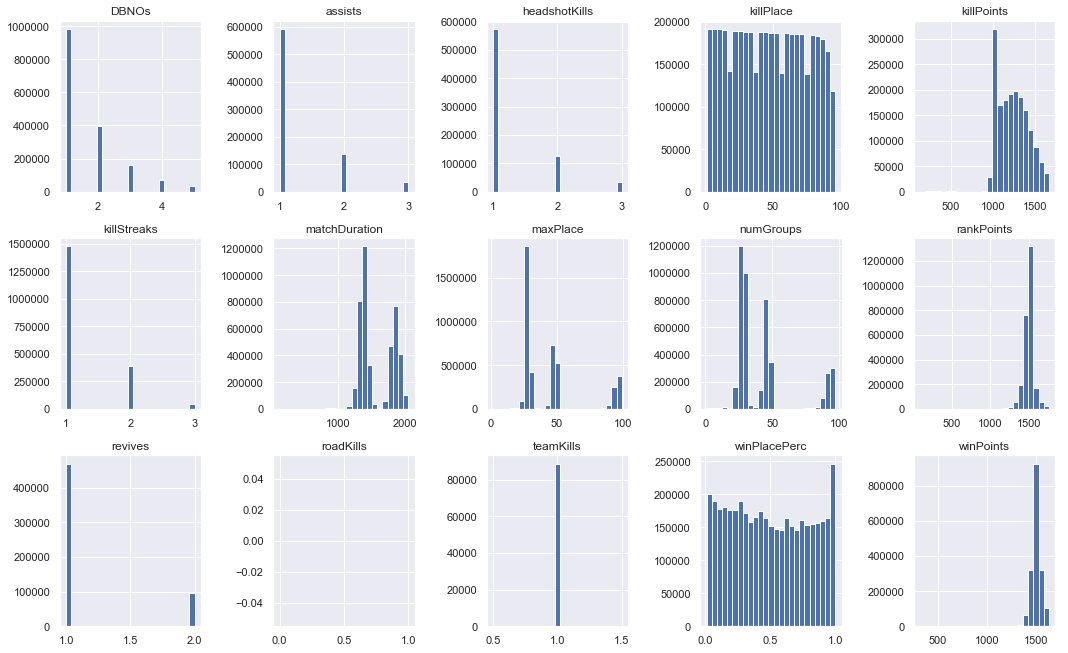

In [ ]:
df = train.drop(columns=['Id','matchId','groupId','matchType']+features)
df[(df>0) & (df<=df.quantile(0.99))].hist(bins=25,layout=(5,5),figsize=(15,15));
plt.tight_layout()

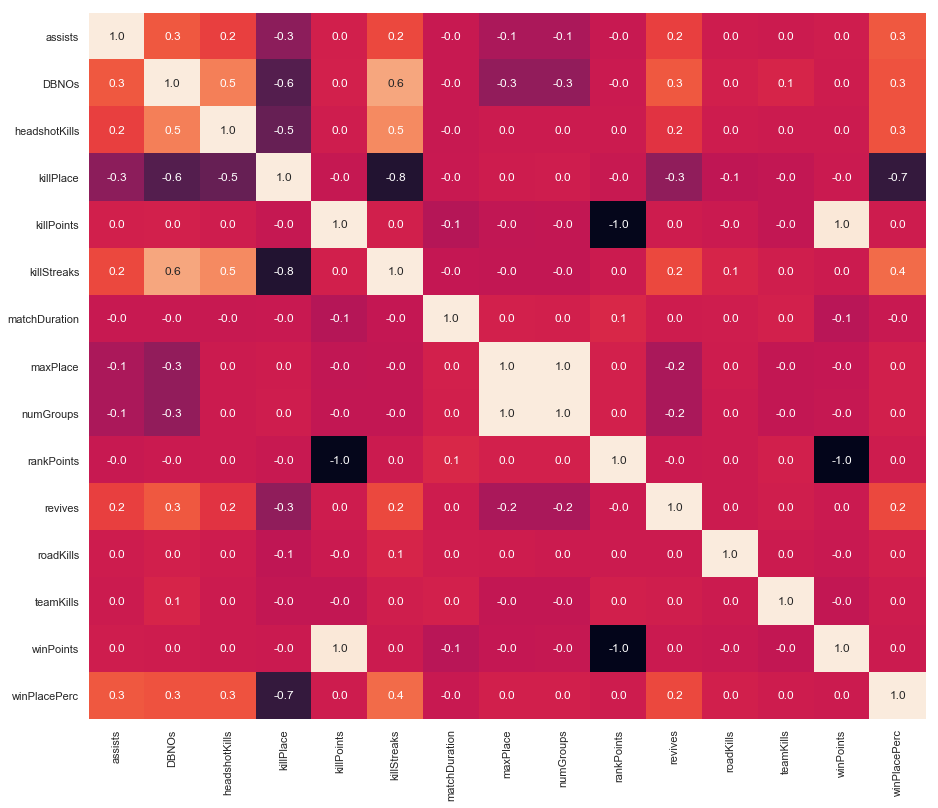

In [ ]:
f,ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df.corr(), annot=True, fmt= '.1f',ax=ax,cbar=False)
plt.show()

walkDistance, killPlace, boosts, weaponsAcquired, damageDealt  most correlate with target feature


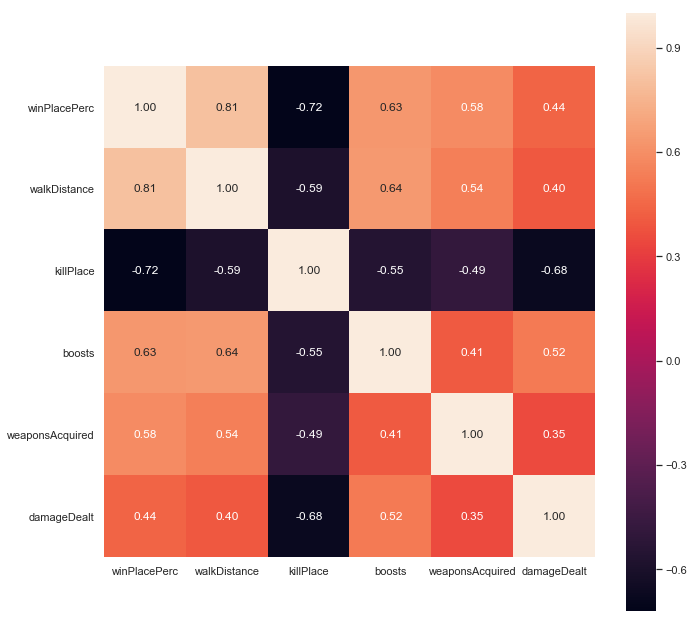

In [ ]:
f,ax = plt.subplots(figsize=(11, 11))
cols = abs(train.corr()).nlargest(6, 'winPlacePerc')['winPlacePerc'].index
hm = sns.heatmap(np.corrcoef(train[cols].values.T), annot=True, square=True, fmt='.2f',  yticklabels=cols.values, xticklabels=cols.values)
print(", ".join(cols[1:]), " most correlate with target feature")
plt.show()

In [ ]:
sns.set(font_scale=2)
sns.pairplot(train, y_vars=["winPlacePerc"], x_vars=cols[1:],height=8);
sns.set(font_scale=1)

In [ ]:
print("Number of match in train dataset:",train['matchId'].nunique())

In [ ]:
playersJoined = train.groupby('matchId')['matchId'].transform('count')
sns.countplot(playersJoined[playersJoined>=75])
plt.title('playersJoined');

In [ ]:
ngroupsByMatch = train.groupby('matchId')['groupId'].nunique()
ax = sns.countplot(ngroupsByMatch)
plt.title('Number of groups by match');
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5)) #Starts from 0 not from 1:(

In [ ]:
train.matchDuration.hist(bins=50);

In [ ]:
plt.rcParams['figure.figsize'] = 18,7;
types = train.groupby('matchType').size().sort_values(ascending=False)
sns.barplot(x=types.index,y=types.values);
plt.title("Number of players by matchType");
plt.tight_layout()

In [ ]:
def _min(x):
    return x.value_counts().values.min()
def _max(x):
    return x.value_counts().values.max()
def _avg(x):
    return x.value_counts().values.mean()
def _med(x):
    return np.median(x.value_counts().values)
def _num(x):
    return x.nunique()
infostat = train.groupby('matchType').agg({
    "matchId": [np.size, _num, _min,_med,_max], #np.size - number of players, _num - number of matches
    "groupId": [_min,_med,_max],
    "matchDuration": [min,np.median, max], 
    "maxPlace": [min,np.median,max],
    "numGroups":[min,np.median,max]
    }).sort_values(by=('matchId','size'),ascending=False)  
display(infostat)

In [ ]:
import lightgbm as lgb

In [ ]:
# Function, which reduce memory usage. 
# This function I took from ready kernel (https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def initial_preparing(df, Debug):
    if Debug:
        df = df[df['matchId'].isin(df['matchId'].unique()[:2000])]
    # Drop next columns. *Points features don't correlate with target feature, need
    # more EDA to understand how they work.
    df.drop(columns=['killPoints','rankPoints','winPoints','matchType','maxPlace','Id'],inplace=True)
    X = df.groupby(['matchId','groupId']).agg(np.mean)
    X = reduce_mem_usage(X)
    y = X['winPlacePerc']     
    X.drop(columns=['winPlacePerc'],inplace=True)
    X_ranked = X.groupby('matchId').rank(pct=True)
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, how='left', on=['matchId', 'groupId'] )
    X.drop(['matchId','groupId'],axis=1, inplace=True)
    X = reduce_mem_usage(X)
    return X, y

In [ ]:
X_train, y = initial_preparing(train.copy(),False)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y, test_size=0.2, random_state=666)

In [ ]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train.reset_index(drop=True))
res = lgb.cv({'metric': 'mae'},lgtrain, nfold=5,stratified=False,seed=666)
print("Mean score:",res['l1-mean'][-1])
gc.collect()

In [ ]:
team_features = {
        'assists': [sum, np.mean, np.size], #np.size - size of team
        'boosts' : [sum, np.var, np.mean], 
        'heals': [sum, np.var, np.mean],
        'damageDealt': [np.var,min,max,np.mean],
        'DBNOs': [np.var,max,np.mean],
        'headshotKills': [max,np.mean],
        'killPlaceScall':[sum, min,max, np.var, np.mean],
        'kills': [ sum, max, np.var,np.mean],
        'killStreaks': [max,np.var,np.mean],
        'longestKill': [max, np.mean, np.var],
        'revives': sum,
        'rideDistance': [sum, np.mean,np.var],
        'swimDistance': [np.var],
        'teamKills': sum,
        'vehicleDestroys': sum,
        'walkDistance': [np.var,np.mean],
        'weaponsAcquired': [np.mean],
        'damageRate': [np.var,min,max,np.mean],
        'headshotRate': [np.var,max,np.mean],
        'killStreakRate': [np.var,np.max, np.mean],
        'healthItems': [np.var, np.mean],
        'healsOnKill': [ np.var, np.mean],
        'sniper': [ np.var, np.mean],
        'totalDistance': [sum, np.var, np.mean],
        'totalDistancePen': [ sum ,np.var, np.mean],
        'killsPerRoadDist': [np.mean],
        'killsPerWalkDist': [np.mean],
        'killsPerDist': [np.mean],
        'distance_over_weapons': [np.mean],
        'walkDistance_over_heals': [np.mean],
        'skill': [np.var,np.mean]
}

In [ ]:
def featuring(df, isTrain, Debug):
    y=None
    if Debug:
        df = df[df['matchId'].isin(df['matchId'].unique()[:2000])]
 
    #Creating new features
    #_________________________________________________________________________________________

    nplayers = df.groupby('matchId')['matchId'].transform('count')
    df['killPlaceScall'] = df['killPlace'] / nplayers
    df['damageRate'] = df['kills']/(0.01*df['damageDealt'])
    df['headshotRate'] = df['headshotKills']/df['kills']
    df['killStreakRate'] = df['killStreaks']/df['kills']
    df['healthItems'] = df['heals'] + df['boosts']
    df['healsOnKill'] = df['healthItems']/df['kills']
    df['sniper'] = df['longestKill']/100*df['weaponsAcquired']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['totalDistancePen'] = df['rideDistance']/5 + df["walkDistance"] + df["swimDistance"]*10
    df['killsPerRoadDist'] = df['roadKills'] / (df['rideDistance']+1)
    df['killsPerWalkDist'] = (df['kills']-df['roadKills']) / (df['walkDistance']+1)
    df['killsPerDist'] = df['kills']/(df['totalDistance']+1)
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance']/100/df['heals']
    df["skill"] = df["headshotKills"] + df["roadKills"] - df['teamKills'] 
    df.fillna(0,inplace=True)
    df.replace(np.inf, 0, inplace=True)
    #_________________________________________________________________________________________
    
    ids = df[['matchId','groupId','Id']]
    df.drop(columns=['killPlace','killPoints','rankPoints','winPoints','matchType','maxPlace','Id'],inplace=True)
    
    tfeatures = team_features.copy()
    if isTrain:
        tfeatures['winPlacePerc'] = max
    X = df.groupby(['matchId','groupId']).agg(tfeatures)
    X.fillna(0,inplace=True)
    X.replace(np.inf, 1000000, inplace=True)
    X = reduce_mem_usage(X)    
    if isTrain:
        y = X[('winPlacePerc','max')]     
        X.drop(columns=[('winPlacePerc','max')],inplace=True)
             
   
    #Group dataset by matches. To each match apply ranking 
    X_ranked = X.groupby('matchId').rank(pct=True)    
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, suffixes=["", "_rank"], how='left', on=['matchId', 'groupId'] )

    ids_after = X[['matchId','groupId']]
    ids_after.columns = ['matchId','groupId']
    
    X = X.drop(['matchId','groupId'],axis=1)
    X.columns = [a+"_"+b for a,b in X.columns]
    X = reduce_mem_usage(X)
    
    return X, y, ids,ids_after

In [ ]:
%%time
X_train, y, _,_ = featuring(train,True,False)
X_test, _,ids_init,ids_after = featuring(test,False,False)

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y, test_size=0.2, random_state=666)

In [ ]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train.reset_index(drop=True))
res = lgb.cv({'metric': 'mae'},lgtrain, nfold=5,stratified=False,seed=666)
print("Mean score:",res['l1-mean'][-1])

In [ ]:
gridParams = {
    'num_leaves': [30,50,100], 'max_depth': [-1,8,15], 
    'min_data_in_leaf': [100,300,500], 'max_bin': [250,500], 
    'lambda_l1': [0.01], 'num_iterations': [5], 
    'nthread': [4], 'seed': [666],
    'learning_rate': [0.05], 'metric': ['mae'],
    "bagging_fraction" : [0.7], "bagging_seed" : [0], "colsample_bytree" : [0.7]
    }
model = lgb.LGBMRegressor()
grid = GridSearchCV(model, gridParams,
                    verbose=1,
                    cv=5)

In [ ]:
%%time
grid.fit(X_train.iloc[:500000,:], y_train.iloc[:500000])

In [ ]:
print("Best params:", grid.best_params_)
print("\nBest score:", grid.best_score_)
params = grid.best_params_

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
model = lgb.LGBMRegressor(learning_rate=0.05,nthread=4)

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_learning_curve():
    train_sizes = [1000,5000,10000,50000,100000,500000]
    N_train, val_train, val_test = learning_curve(model,
    X_train, y_train, train_sizes=train_sizes, cv=5,
    scoring='neg_mean_absolute_error')
    plot_with_err(N_train, abs(val_train), label='training scores')
    plot_with_err(N_train, abs(val_test), label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('MAE')
    plt.legend()

plot_learning_curve()

In [ ]:
def iter_vs_score(num_iterations):
    val_train, val_test = validation_curve(model, X_train[:500000], y_train[:500000],
        'num_iterations', num_iterations, cv=4,scoring='neg_mean_absolute_error', verbose=1)
    plot_with_err(num_iterations, abs(val_test), label='validation scores')
    plot_with_err(num_iterations, abs(val_train), label='training scores')
    plt.xlabel('Number of iterations'); plt.ylabel('MAE')
    plt.legend();
    plt.show();

num_iterations_small = [5,10,20,30,100,200]
iter_vs_score(num_iterations_small)
num_iterations_big = [500,1000,5000,10000]
iter_vs_score(num_iterations_big)

In [ ]:
%%time
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_holdout, label=y_holdout)

params['num_iterations'] = 5000
model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], early_stopping_rounds=200, verbose_eval=1000)

In [ ]:
pred_test = model.predict(X_test, num_iteration=model.best_iteration)

ids_after['winPlacePerc'] = pred_test
predict = ids_init.merge(ids_after, how='left', on=['groupId',"matchId"])['winPlacePerc']
df_sub = pd.read_csv("../input/sample_submission_V2.csv")
df_test = pd.read_csv("../input/test_V2.csv")
df_sub['winPlacePerc'] = predict
df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)